# Facial Segmentation
- Segment people into groups by photo similar to the IPhone photos app 

In [1]:
import os, sys
import cv2
import numpy as np
from numpy import asarray
import pandas as pd
import imageai
from tqdm import tqdm
from imageai.Detection.Custom import DetectionModelTrainer
from imageai.Detection.Custom import CustomObjectDetection
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

c:\Users\Matt\anaconda3\envs\fd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load Images**

In [2]:
img_path = r'C:\Users\Matt\OneDrive\GitHub\Face-Segmentation\pics\train\images'
images = os.listdir(img_path)

**Train Model**

In [3]:
path = r"C:\Users\Matt\OneDrive\GitHub\SmartMirror\SmartMirror\pics\models\tiny-yolov3.pt"
# train = DetectionModelTrainer()
# train.setModelTypeAsTinyYOLOv3()
# train.setDataDirectory(data_directory=r"C:\Users\Matt\OneDrive\GitHub\PersonDetection\pics")
# train.setTrainConfig(
#     object_names_array=['face'],
#     batch_size=4,
#     train_from_pretrained_model=path,
#     num_experiments=1000,
#     )
# train.trainModel()

train.setTrainConfig(
    object_names_array=['face'],
    batch_size=4,
    train_from_pretrained_model=path,
    num_experiments=1000,
    
    )

In [4]:
model_path = r"C:\Users\Matt\OneDrive\GitHub\Face-Segmentation\pics\models\tiny-yolov3_pics_last.pt"
json_path = r"C:\Users\Matt\OneDrive\GitHub\Face-Segmentation\pics\json\pics_tiny-yolov3_detection_config.json"
detector = CustomObjectDetection()
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath(model_path)
detector.setJsonPath(json_path)
detector.loadModel()

# Resize Images

In [5]:
# save_path = r"C:\Users\Matt\OneDrive\GitHub\PersonDetection\resized_pics"
# for i in tqdm(images): 
#     image = Image.open(os.path.join(img_path,i,))
#     resize = image.resize((400,400))
#     resize.save(os.path.join(save_path, i))

# Test resizing
# resize.save('test3.jpg')

**Detect People in Images**

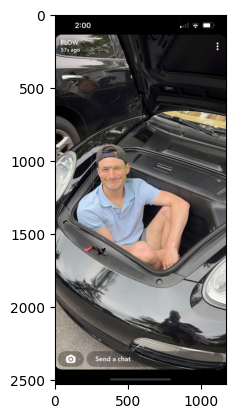

In [6]:
res = detector.detectObjectsFromImage(
    input_image = os.path.join(img_path, images[1]),
    output_image_path='test4.jpg',
    minimum_percentage_probability=45
)
plt.imshow(Image.open('test4.jpg'))

In [7]:
res[0]

{'name': 'face',
 'percentage_probability': 52.94,
 'box_points': [250, 941, 477, 1156]}

# Trim image to box shape

In [8]:
coords = res[0]['box_points']

**Grab Faces**

In [9]:
img = cv2.imread('test4.jpg')
cropped = img[coords[1]:coords[3],coords[0]:coords[2]] # img[y:range, x:range]
# cv2.imshow('cropped',cropped)
# cv2.waitKey(0)

# Make predictions on entire feature set 

In [10]:
# Make predictions and grab faces on test images 
def predict(img): 
    res = detector.detectObjectsFromImage(
    input_image = os.path.join(img_path,img),
    output_image_path='test2.jpg',
    minimum_percentage_probability=45
    )
    return res

In [11]:
preds = list()
photo = list()
for image in tqdm(images): 
    preds.append(predict(image))

100%|██████████| 110/110 [00:20<00:00,  5.49it/s]


**Aggregate 1-many relationship as each photo can have multiple faces**

In [12]:
master_imgs = list()
master_preds = list()
for img in range(len(images)): 
    for pred in preds[img]:
        master_imgs.append(images[img])
        master_preds.append(pred)
df = pd.DataFrame([master_imgs,master_preds],index=['Image','Prediction']).T
df[:1]

,Image,Prediction
0,03661a93-fe0ddc57-9c5f4f3c-d1ad-45c7-b8b1-6442...,"{'name': 'face', 'percentage_probability': 46...."


### img[coords[1]:coords[3],coords[0]:coords[2]] # img[y:range, x:range]

In [13]:
df['coord 0'] = df['Prediction'].str['box_points'].str[0]
df['coord 1'] = df['Prediction'].str['box_points'].str[1]
df['coord 2'] = df['Prediction'].str['box_points'].str[2]
df['coord 3'] = df['Prediction'].str['box_points'].str[3]

**Crop each face of each image detected by model**

In [28]:

def crop(image, x1,x2,y1,y2): 
    # load img
    i = cv2.imread(os.path.join(img_path, image), cv2.IMREAD_GRAYSCALE)
    # crop img
    return i[y1:y2,x1:x2]#.flatten()

In [29]:
# Crop Image set 
df['crop'] = None
for i in tqdm(range(len(df))): 
    df['crop'][i] = crop(os.path.join(img_path,df['Image'][i]),
                      df['coord 1'][i],
                      df['coord 3'][i],
                      df['coord 0'][i],
                      df['coord 2'][i],
        )

100%|██████████| 334/334 [00:08<00:00, 38.66it/s]


# Analysis

### Thought Process
- PCA to reduce to 2 dimentions
- KMeans clustering to determine similarities between photos

**Issues**
- Data shape is not consistent, poses issues when fitting PCA
    - Potential fix: Scale face images to same dimentions? 

In [23]:
df['crop'][0].shape

(14420,)

In [24]:
df['crop'][1].shape

(12672,)

In [32]:
df['crop'][0].reshape(1,-1)

array([[64, 64, 64, ..., 53, 53, 53]], dtype=uint8)

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
c = cosine_similarity(df['crop'][0].reshape(1,-1),df['crop'][1].reshape(1,-1))

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 14420 while Y.shape[1] == 12672